# Liquidity Integrated Long Term Portfolio

In this notebook we set out to analyze a Long-Term return portfolio in conjunction with allocation to money market funds and add some constraints for integrating liquidity into the portfolio

In [93]:
#fetching data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import LinearConstraint, Bounds, minimize

try:
    import pdblp

    con = pdblp.BCon(debug=True, port=8194, timeout=5000)
    con.start()
    con.debug = False
except:
    pass

In [94]:
tickers = ['SPY US Equity', 'EEM US Equity', 'REET US Equity', 'ALTY US Equity', 'IPO US Equity', 'VBK US Equity', 
           'PSP US Equity', 'IGEB US Equity', 'TLH US Equity', 'VYM US Equity', 'TLT US Equity']

start_date = '20171001'
end_date = '20241001'
rf = 3.78/100

try:
    return_index = pd.read_csv(r'universe_index_returns.csv', header=0, index_col=0)
    return_index.index = pd.to_datetime(return_index.index)
    
except:
    return_index = pd.DataFrame()
    
    for ticker in tickers:
        print(ticker)
        rt = con.bdh(ticker, ['TOT_RETURN_INDEX_NET_DVDS'], start_date, end_date)
        rt = rt[ticker][rt[ticker].columns[0]]
        if ticker == 'SPY US Equity':
            return_index.index = rt.index
            return_index[ticker] = rt.values
        else:
            rt.name = ticker
            return_index = return_index.merge(rt, on=['date'], how = 'left')

return_index

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,252.3200,44.8200,25.5500,15.7100,26.7797,153.8400,63.4500,50.4126,136.1600,81.5300,124.2800
2017-10-31,257.1500,46.2800,25.3100,15.5190,28.0400,156.1900,64.1000,50.5300,136.1000,82.4800,124.4600
2017-11-30,265.0100,46.1000,26.0300,15.4757,27.7953,160.9800,62.6000,50.5684,135.8984,85.0100,125.3839
2017-12-29,268.2131,47.8374,26.3659,15.6109,28.2089,161.4039,64.0802,50.5876,136.6807,86.2729,127.6508
2018-01-31,283.3294,51.8069,25.9616,15.6212,28.3340,167.6654,68.6096,50.5007,133.1232,89.8194,123.4950
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,588.3497,48.6078,29.6061,19.1468,39.6741,260.4799,97.3776,58.3782,120.1737,147.4197,105.7993
2024-06-28,609.1095,49.8814,29.9060,19.2511,40.7742,260.8175,95.6467,58.7169,122.0315,146.9544,107.7163
2024-07-31,616.4852,50.3030,31.7840,19.8841,40.7033,272.5795,102.2069,60.1582,126.2809,154.0543,111.6327


In [95]:
# Converting to monthly returns
return_index = return_index.ffill()
dates = pd.date_range(start = start_date, end = end_date, freq= 'M')
return_index['date'] = return_index.index
return_index_monthly = pd.DataFrame(columns = return_index.columns)
return_index_monthly.loc[len(return_index_monthly)] = return_index.iloc[0]

for i in range(len(dates)):
    temp = return_index[(return_index['date'] <= dates[i])]
    return_index_monthly.loc[len(return_index_monthly)] = temp.iloc[-1]

return_index_monthly.set_index('date', inplace=True)
returns_monthly = return_index_monthly.pct_change()
returns_monthly

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-31,0.019142,0.032575,-0.009393,-0.012158,0.047062,0.015276,0.010244,0.002329,-0.000441,0.011652,0.001448
2017-11-30,0.030566,-0.003889,0.028447,-0.002790,-0.008727,0.030668,-0.023401,0.000760,-0.001481,0.030674,0.007423
2017-12-29,0.012087,0.037688,0.012904,0.008736,0.014880,0.002633,0.023645,0.000380,0.005757,0.014856,0.018080
2018-01-31,0.056359,0.082979,-0.015334,0.000660,0.004435,0.038794,0.070683,-0.001718,-0.026028,0.041108,-0.032556
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.050580,0.019517,0.043850,0.023510,0.055420,0.035165,0.039055,0.020991,0.027923,0.030308,0.028841
2024-06-28,0.035285,0.026202,0.010130,0.005447,0.027728,0.001296,-0.017775,0.005802,0.015459,-0.003156,0.018119
2024-07-31,0.012109,0.008452,0.062797,0.032881,-0.001739,0.045097,0.068588,0.024547,0.034822,0.048314,0.036358


In [96]:
# Creating a standard 60/40 Portfolio (60% Equity and 40% US 10 Yr T-Bills
blk_life = pd.read_csv(r'blackrock_life_index_returns.csv', index_col=0, header=0)
blk_life.rename(columns={'LIPKX US Equity': 'portfolio'}, inplace=True)
blk_life = blk_life.loc[blk_life.index[23]:]
blk_life.iloc[0] = [0]
blk_life.index = pd.to_datetime(blk_life.index)
blk_life

,portfolio
date,
2019-08-30,0.000000
2019-09-30,0.021263
2019-10-31,0.025107
2019-11-29,0.024492
2019-12-31,0.032653
...,...
2024-05-31,0.043672
2024-06-28,0.017435
2024-07-31,0.023610


In [97]:
# Getting Cumulative Returns for the 60/40 Portfolio
blk_life_cumulative = (blk_life.fillna(0) + 1).cumprod()
blk_life_cumulative

,portfolio
date,
2019-08-30,1.000000
2019-09-30,1.021263
2019-10-31,1.046904
2019-11-29,1.072545
2019-12-31,1.107567
...,...
2024-05-31,1.614134
2024-06-28,1.642276
2024-07-31,1.681051


In [98]:
money_market_funds = pd.read_csv(r"money_market_funds_spaxx_us_equity.csv", header=0, index_col=0)
money_market_funds.rename(columns={'TOT_RETURN_INDEX_NET_DVDS': 'money_market'}, inplace=True)
money_market_funds.index = pd.to_datetime(money_market_funds.index)

money_market_funds = money_market_funds.ffill()
dates = pd.date_range(start = start_date, end = end_date, freq= 'M')
money_market_funds['date'] = money_market_funds.index
money_market_funds_monthly = pd.DataFrame(columns = money_market_funds.columns)
money_market_funds_monthly.loc[len(money_market_funds_monthly)] = money_market_funds.iloc[0]

for i in range(len(dates)):
    temp = money_market_funds[(money_market_funds['date'] <= dates[i])]
    money_market_funds_monthly.loc[len(money_market_funds_monthly)] = temp.iloc[-1]

money_market_funds_monthly.set_index('date', inplace=True)
money_market_funds_returns_monthly = money_market_funds_monthly.pct_change()
money_market_funds_returns_monthly

,money_market
date,
2017-10-02,NaN
2017-10-31,0.000000
2017-11-30,0.000000
2017-12-28,0.000000
2018-01-31,0.000000
...,...
2024-05-30,0.000000
2024-06-27,0.008929
2024-07-31,0.000000


# Backtest

In [99]:
import warnings
warnings.filterwarnings("ignore")

optimal_weights = pd.DataFrame(columns = tickers)
returns_monthly = returns_monthly[tickers]
# print(returns_monthly.head)
optimal_vol = {}
prev_date = returns_monthly.index[23]

# We do a 5 year backtest and use historical covriances and returns as our estimates of expected returns and expected covariances
for date in returns_monthly.index[24:]:
    temp_returns = returns_monthly.loc[:date]
    returns = list(temp_returns.mean().values)
    cov_matrix = temp_returns.cov()

    def vol(x):
        return (np.matrix(x)*(np.matrix(cov_matrix))*np.matrix(x).T)[0,0]

    def return_constraint(target_return):
        return LinearConstraint(returns, target_return/12, np.inf)

    weight_sum_constraint = LinearConstraint(np.ones([1,11]), 1, 1)
    min_weight_constraint = LinearConstraint(np.eye(11), lb=0.01)
    x0 = [1/11]*11

    solution = minimize(vol, x0, method='trust-constr', constraints = [
        weight_sum_constraint, min_weight_constraint, return_constraint(0.14)])
    if solution.success:
        optimal_weights.loc[date] = solution.x
        optimal_vol[date] = (solution.fun*12)**0.5
    else:
        optimal_weights.loc[date] = optimal_weights.loc[prev_date]
        optimal_vol[date] = optimal_vol[prev_date]
    prev_date = date

In [100]:
optimal_returns = (np.matrix(optimal_weights)*np.matrix(returns_monthly.loc[returns_monthly.index[24]:].T)).diagonal()
optimal_returns = np.squeeze(np.asarray(optimal_returns))

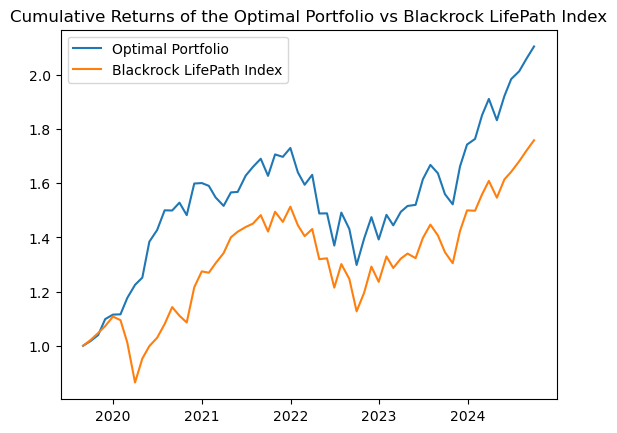

Blackrock LifePath Index Mean Return (%):  12.45
Optimal Portfolio Mean Return (%):  15.59
Blackrock LifePath Inded Vol (%):  17.21
Optimal Portfolio Vol (%):  14.93
Blackrock LifePath Index Sharpe:  0.5
Optimal Portfolio Sharpe:  0.79


In [101]:
optimal_returns_df = pd.DataFrame(data = np.matrix(optimal_returns).T ,columns = ['opt_port_monthly_returns'], 
                                  index = returns_monthly.index[24:])
optimal_returns_df.loc[returns_monthly.index[23]] = 0
optimal_returns_df.sort_index(inplace=True)
optimal_returns_df['cumulative_returns'] = (optimal_returns_df['opt_port_monthly_returns'] + 1).cumprod()
optimal_returns_df

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(blk_life_cumulative['portfolio'], label='Blackrock LifePath Index')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs Blackrock LifePath Index')
plt.show()

print('Blackrock LifePath Index Mean Return (%): ', round(blk_life['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print('Blackrock LifePath Inded Vol (%): ', round(blk_life['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print('Blackrock LifePath Index Sharpe: ', 
      round((blk_life['portfolio'].mean()*12 - rf)/(blk_life['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))

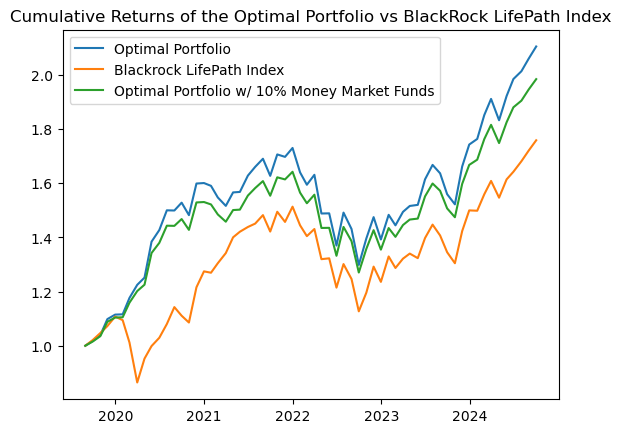

6BlackRock LifePath Index Mean Return (%):  12.45
Optimal Portfolio Mean Return (%):  15.59
Optimal Portfolio w/ Money Market Mean Return (%):  14.23
BlackRock LifePath Index Vol (%):  17.21
Optimal Portfolio Vol (%):  14.93
Optimal Portfolio w/ Money Market Vol (%):  13.45
BlackRock LifePath Index Sharpe:  0.5
Optimal Portfolio Sharpe:  0.79
Optimal Portfolio w/ Money Market Sharpe:  0.78


In [102]:
optimal_returns_df.reset_index(inplace=True)
optimal_returns_df['money_market_returns'] = list(money_market_funds_returns_monthly.reset_index().iloc[23:]['money_market'])
optimal_returns_df['opt_port_w_money_market'] = 0.9*optimal_returns_df['opt_port_monthly_returns'] + 0.1*optimal_returns_df[
    'money_market_returns']
optimal_returns_df['opt_port_w_money_market_cumulative'] = (optimal_returns_df['opt_port_w_money_market'] + 1).cumprod()
optimal_returns_df.set_index('date', inplace=True)

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(blk_life_cumulative['portfolio'], label='Blackrock LifePath Index')
plt.plot(optimal_returns_df['opt_port_w_money_market_cumulative'], label='Optimal Portfolio w/ 10% Money Market Funds')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs BlackRock LifePath Index')
plt.show()

print('6BlackRock LifePath Index Mean Return (%): ', round(blk_life['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print(f'Optimal Portfolio w/ Money Market Mean Return (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].mean()*12*100, 2))

print('BlackRock LifePath Index Vol (%): ', round(blk_life['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio w/ Money Market Vol (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)*100, 2))

print('BlackRock LifePath Index Sharpe: ', 
      round((blk_life['portfolio'].mean()*12 - rf)/(blk_life['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))
print('Optimal Portfolio w/ Money Market Sharpe: ', 
      round((optimal_returns_df['opt_port_w_money_market'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)), 2))

# Constrained Optimization for Liquidity Management

In [103]:
bid_ask_spread = pd.read_csv(r'historical_bid_ask_%.csv', header=0, index_col=0)
bid_ask_spread.index = pd.to_datetime(bid_ask_spread.index)
bid_ask_spread = bid_ask_spread.reindex(returns_monthly.index)
bid_ask_spread

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,0.0040,0.0223,0.1663,2.8453,0.5122,0.0391,0.1258,0.1233,0.0294,0.0136,0.0085
2017-10-31,0.0039,0.0217,0.1479,NaN,0.3077,0.0519,0.1482,0.1093,0.0257,0.0140,0.0082
2017-11-30,0.0038,0.0216,0.1224,3.6943,0.2825,0.1058,0.1686,0.1118,0.0422,0.0130,0.0081
2017-12-29,0.0038,0.0212,0.1036,3.4485,0.1801,0.0758,0.2193,0.1302,0.0477,0.0132,0.0080
2018-01-31,0.0038,0.0197,0.0958,0.6435,0.1669,0.0738,0.1586,0.1662,0.0477,0.0134,0.0084
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.0027,0.0240,0.0455,0.4651,0.1039,0.0501,0.6735,0.0288,0.0144,0.0121,0.0111
2024-06-28,0.0030,0.0234,0.0456,0.3029,0.0538,0.0513,0.7048,0.0352,0.0155,0.0142,0.0108
2024-07-31,0.0036,0.0233,0.0429,0.4492,0.1228,0.0778,0.4798,0.0292,0.0164,0.0217,0.0106


In [104]:
div_yld = pd.read_csv(r'historical_indicated_div_yld.csv', header=0, index_col=0)
div_yld.ffill(limit=30)
div_yld.index = pd.to_datetime(div_yld.index)
div_yld = div_yld.reindex(returns_monthly.index)
div_yld.fillna(0, inplace=True)
div_yld

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity
date,,,,,,,,,,,
2017-10-02,1.9572,0.8555,3.4670,6.9510,0.2347,0.5408,13.8963,3.2702,1.8300,2.9535,2.4370
2017-10-31,1.9204,0.8285,3.4999,7.0365,0.2241,0.5327,13.7554,3.2959,1.9311,2.9195,2.5365
2017-11-30,1.8634,0.8317,3.4031,7.0978,0.2261,0.5168,14.0850,3.3089,1.8729,2.8326,2.4428
2017-12-29,2.0255,2.9565,0.2700,9.9599,0.0000,1.3782,11.5904,4.4031,2.0944,3.0041,2.4742
2018-01-31,1.9175,2.7300,0.2742,9.9533,0.0000,1.3267,10.8252,3.1511,1.9001,2.8855,2.4889
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,1.2097,3.5800,2.3084,7.0923,0.0000,0.6468,3.2710,5.0572,4.2297,2.1850,4.0901
2024-06-28,1.2929,1.3611,1.2471,7.0955,0.0760,0.6622,23.0355,4.5697,4.0707,3.4526,3.8061
2024-07-31,1.2774,1.3497,1.1734,6.9100,0.0761,0.6336,21.5570,5.0069,3.9778,3.2935,3.9851


In [105]:
optimal_weights = pd.DataFrame(columns = tickers)
returns_monthly = returns_monthly[tickers]
optimal_vol = {}
prev_date = returns_monthly.index[23]
t_cost = []
turnover = []

# We do a 5 year backtest and use historical covriances and returns as our estimates of expected returns and expected covariances
for date in returns_monthly.index[24:]:
    temp_returns = returns_monthly.loc[:date]
    returns = list(temp_returns.mean().values)
    div_yld_at_d = div_yld.loc[date].values
    bid_ask_at_d = bid_ask_spread.loc[date].values
    cov_matrix = temp_returns.cov()

    def vol(x):
        return (np.matrix(x)*(np.matrix(cov_matrix))*np.matrix(x).T)[0,0]

    def return_constraint(target_return):
        return LinearConstraint(returns, target_return/12, np.inf)
    
    def div_yld_constraint(target_div_yld):
        return LinearConstraint(div_yld_at_d, target_div_yld, np.inf)
    
    def bid_ask_constraint(target_bid_ask_spread):
        return LinearConstraint(bid_ask_at_d, 0, target_bid_ask_spread)

    weight_sum_constraint = LinearConstraint(np.ones([1,11]), 1, 1)
    min_weight_constraint = LinearConstraint(np.eye(11), lb=0.01)
    x0 = [1/11]*11

    solution = minimize(vol, x0, method='trust-constr', constraints = [
        weight_sum_constraint, min_weight_constraint, return_constraint(0.14), div_yld_constraint(2.5), bid_ask_constraint(0.1)])
    
    if date == returns_monthly.index[24]:
        t = 1
    else:
        t = solution.x - optimal_weights.loc[prev_date]
        t = t.abs().sum()
    turnover.append(t)
    
    if solution.success:
        optimal_weights.loc[date] = solution.x
        optimal_vol[date] = (solution.fun*12)**0.5
    else:
        optimal_weights.loc[date] = optimal_weights.loc[prev_date]
        optimal_vol[date] = optimal_vol[prev_date]
    prev_date = date

In [106]:
optimal_returns = (np.matrix(optimal_weights)*np.matrix(returns_monthly.loc[returns_monthly.index[24]:].T)).diagonal()
optimal_returns = np.squeeze(np.asarray(optimal_returns))
#Adjusting for transaction costs assuming a t-cost of 10 bps
optimal_returns = optimal_returns - 0.001*np.array(turnover)

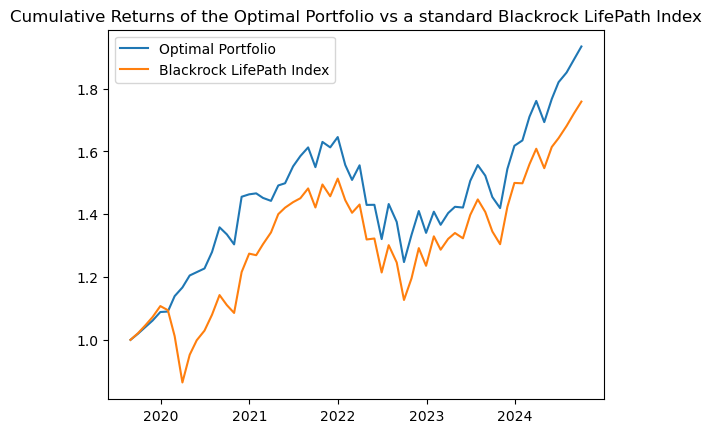

Blackrock LifePath Index Mean Return (%):  12.45
Optimal Portfolio Mean Return (%):  13.81
Blackrock LifePath Index Vol (%):  17.21
Optimal Portfolio Vol (%):  14.12
Blackrock LifePath Index Sharpe:  0.5
Optimal Portfolio Sharpe:  0.71


In [107]:
optimal_returns_df = pd.DataFrame(data = np.matrix(optimal_returns).T ,columns = ['opt_port_monthly_returns'], 
                                  index = returns_monthly.index[24:])
optimal_returns_df.loc[returns_monthly.index[23]] = 0
optimal_returns_df.sort_index(inplace=True)
optimal_returns_df['cumulative_returns'] = (optimal_returns_df['opt_port_monthly_returns'] + 1).cumprod()
optimal_returns_df

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(blk_life_cumulative['portfolio'], label='Blackrock LifePath Index')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs a standard Blackrock LifePath Index')
plt.show()

print('Blackrock LifePath Index Mean Return (%): ', round(blk_life['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print('Blackrock LifePath Index Vol (%): ', round(blk_life['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print('Blackrock LifePath Index Sharpe: ', 
      round((blk_life['portfolio'].mean()*12 - rf)/(blk_life['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))

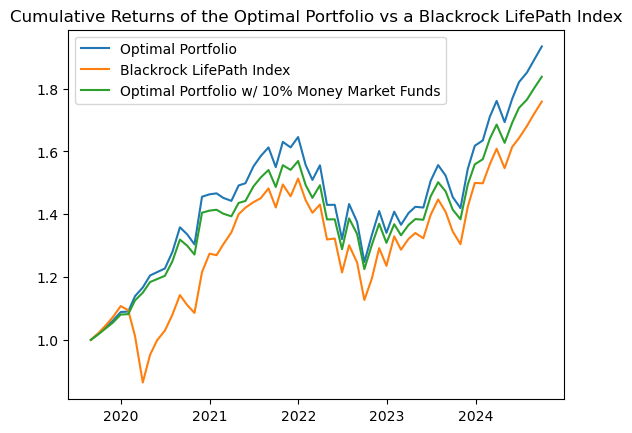

Blackrock LifePath Index Mean Return (%):  12.45
Optimal Portfolio Mean Return (%):  13.81
Optimal Portfolio w/ Money Market Mean Return (%):  12.63
Blackrock LifePath Index Vol (%):  17.21
Optimal Portfolio Vol (%):  14.12
Optimal Portfolio w/ Money Market Vol (%):  12.73
Blackrock LifePath Index Sharpe:  0.5
Optimal Portfolio Sharpe:  0.71
Optimal Portfolio w/ Money Market Sharpe:  0.7


In [108]:
optimal_returns_df.reset_index(inplace=True)
optimal_returns_df['money_market_returns'] = list(money_market_funds_returns_monthly.reset_index().iloc[23:]['money_market'])
optimal_returns_df['opt_port_w_money_market'] = 0.9*optimal_returns_df['opt_port_monthly_returns'] + 0.1*optimal_returns_df[
    'money_market_returns']
optimal_returns_df['opt_port_w_money_market_cumulative'] = (optimal_returns_df['opt_port_w_money_market'] + 1).cumprod()
optimal_returns_df.set_index('date', inplace=True)

plt.plot(optimal_returns_df['cumulative_returns'], label='Optimal Portfolio')
plt.plot(blk_life_cumulative['portfolio'], label='Blackrock LifePath Index')
plt.plot(optimal_returns_df['opt_port_w_money_market_cumulative'], label='Optimal Portfolio w/ 10% Money Market Funds')
plt.legend()
plt.title('Cumulative Returns of the Optimal Portfolio vs a Blackrock LifePath Index')
plt.show()

print('Blackrock LifePath Index Mean Return (%): ', round(blk_life['portfolio'].mean()*12*100, 2))
print(f'Optimal Portfolio Mean Return (%): ', round(optimal_returns_df['opt_port_monthly_returns'].mean()*12*100, 2))
print(f'Optimal Portfolio w/ Money Market Mean Return (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].mean()*12*100, 2))

print('Blackrock LifePath Index Vol (%): ', round(blk_life['portfolio'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio Vol (%): ', round(optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)*100, 2))
print(f'Optimal Portfolio w/ Money Market Vol (%): ', round(
    optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)*100, 2))

print('Blackrock LifePath Index Sharpe: ', 
      round((blk_life['portfolio'].mean()*12 - rf)/(blk_life['portfolio'].std()*(12**0.5)), 2))
print('Optimal Portfolio Sharpe: ', 
      round((optimal_returns_df['opt_port_monthly_returns'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_monthly_returns'].std()*(12**0.5)), 2))
print('Optimal Portfolio w/ Money Market Sharpe: ', 
      round((optimal_returns_df['opt_port_w_money_market'].mean()*12 - rf)/(
          optimal_returns_df['opt_port_w_money_market'].std()*(12**0.5)), 2))

In [146]:
optimal_returns_df['drawdown'] = (
    optimal_returns_df['opt_port_w_money_market_cumulative'] - optimal_returns_df[
        'opt_port_w_money_market_cumulative'].cummax())/optimal_returns_df['opt_port_w_money_market_cumulative'].cummax()
drawdown_duration = len(optimal_returns_df[optimal_returns_df['drawdown'] < 0].iloc[5:-1])
print('Max Drawdown of Optimal Portfolio:', -optimal_returns_df['drawdown'].min())
print('Max Drawdown Duration of Optimal Portfolio:', drawdown_duration, 'months')

blk_life_cumulative['drawdown'] = (
    blk_life_cumulative['portfolio'] - blk_life_cumulative['portfolio'].cummax())/blk_life_cumulative['portfolio'].cummax()
drawdown_duration = len(blk_life_cumulative[blk_life_cumulative['drawdown'] < 0][11:-1])
print('Max Drawdown of Blackrock LifePath Index:', -blk_life_cumulative['drawdown'].min())
print('Max Drawdown Duration of Blackrock LifePath Index:', drawdown_duration, 'months')

Max Drawdown of Optimal Portfolio: 0.21929093655047283
Max Drawdown Duration of Optimal Portfolio: 25 months
Max Drawdown of Blackrock LifePath Index: 0.2553719008264462
Max Drawdown Duration of Blackrock LifePath Index: 26 months


In [183]:
returns_monthly = returns_monthly.reindex(blk_life.index)
returns_monthly['Optimal Portfolio'] = optimal_returns_df['opt_port_w_money_market']
returns_monthly['Blackrock Life Index'] = blk_life['portfolio']
returns_monthly['Money Market'] = money_market_funds_monthly.reindex(blk_life.index)['money_market']
corr_matrix = returns_monthly.corr().loc['Optimal Portfolio':]
corr_matrix

,SPY US Equity,EEM US Equity,REET US Equity,ALTY US Equity,IPO US Equity,VBK US Equity,PSP US Equity,IGEB US Equity,TLH US Equity,VYM US Equity,TLT US Equity,Optimal Portfolio,Blackrock Life Index,Money Market
Optimal Portfolio,0.801719,0.568383,0.663284,0.455033,0.646282,0.712486,0.701169,0.642819,0.572781,0.644378,0.546978,1.000000,0.780697,0.088206
Blackrock Life Index,0.976087,0.807617,0.911878,0.870618,0.710472,0.904729,0.948672,0.775330,0.329252,0.908386,0.307996,0.780697,1.000000,0.065119
Money Market,0.070412,0.052691,0.085253,0.080673,0.075484,0.102147,0.186820,0.129016,0.067915,0.046082,0.032751,0.088206,0.065119,1.000000


In [192]:
optimal_portfolio_beta = corr_matrix.iloc[0,0]*returns_monthly['Optimal Portfolio'].std()/returns_monthly['SPY US Equity'].std()
blackrock_life_beta = corr_matrix.iloc[0,0]*returns_monthly['Blackrock Life Index'].std()/returns_monthly['SPY US Equity'].std()
print('Optimal Portfolio Equity Beta:',optimal_portfolio_beta)
print('Blackrock LifePath Index Equity Beta:',blackrock_life_beta)

Optimal Portfolio Equity Beta: 0.5746465310018216
Blackrock LifePath Index Equity Beta: 0.7771397037062533


# Adjustment for Age

In [ ]:
def vol(x):
        return (np.matrix(x)*(np.matrix(cov_matrix))*np.matrix(x).T)[0,0]

    def return_constraint(target_return):
        return LinearConstraint(returns, target_return/12, np.inf)
    
    def div_yld_constraint(target_div_yld):
        return LinearConstraint(div_yld_at_d, target_div_yld, np.inf)
    
    def bid_ask_constraint(target_bid_ask_spread):
        return LinearConstraint(bid_ask_at_d, 0, target_bid_ask_spread)

weight_sum_constraint = LinearConstraint(np.ones([1,11]), 1, 1)
min_weight_constraint = LinearConstraint(np.eye(11), lb=0.01)
x0 = [1/11]*11

solution = minimize(vol, x0, method='trust-constr', constraints = [
    weight_sum_constraint, min_weight_constraint, return_constraint(0.14), div_yld_constraint(2.5), bid_ask_constraint(0.1)])